In [1]:
!pip3 install scikit-learn tqdm catboost optuna xgboost ipywidgets imblearn

In [115]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import StratifiedKFold


In [116]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

In [117]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [118]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    'customer_idx',
    'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""
    
    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

        
def manage_label_encoding(df_train, df_test):
    tmp = len(df_train)
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]
    
    df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

    for col in label_columns:
        df_all[col] = label_encoding(df_all[col])
    
    for col in label_columns:  
        df_train[col] = df_all.iloc[: tmp][col]
        df_test[col] = df_all.iloc[tmp :][col]

    return df_train, df_test

def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')

    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    robustScaler = RobustScaler()
    df_train['ver_win_rate_x'] = robustScaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x'] = robustScaler.transform(df_test[['ver_win_rate_x']])
    robustScaler = RobustScaler()
    df_train['ver_win_ratio_per_bu'] = robustScaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu'] = robustScaler.transform(df_test[['ver_win_ratio_per_bu']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [119]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    ]

S_kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

In [139]:
def objective(trial):
    params = {
        'iterations':trial.suggest_int("iterations", 10000, 50000),
        'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
        'reg_lambda': trial.suggest_uniform('reg_lambda',10,100),
        'random_strength': trial.suggest_uniform('random_strength',40,100),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
        'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
        'bagging_temperature' :trial.suggest_uniform('bagging_temperature', 0, 1),
        'verbose':False,
        'random_state':seed,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 early_stopping_rounds=100
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-02-18 03:06:13,750] A new study created in memory with name: no-name-c5d90bdf-a01e-4120-b7e3-5314a2b91602
[I 2024-02-18 03:07:17,859] Trial 0 finished with value: 0.7614125714722839 and parameters: {'iterations': 24981, 'learning_rate': 0.9507635921035062, 'reg_lambda': 75.87945476302646, 'random_strength': 75.91950905182219, 'min_data_in_leaf': 8, 'leaf_estimation_iterations': 3, 'bagging_temperature': 0.05808361216819946}. Best is trial 0 with value: 0.7614125714722839.
[I 2024-02-18 03:08:40,047] Trial 1 finished with value: 0.7798518013794101 and parameters: {'iterations': 44647, 'learning_rate': 0.6015138967314656, 'reg_lambda': 73.7265320016441, 'random_strength': 41.23506965774815, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.21233911067827616}. Best is trial 1 with value: 0.7798518013794101.
[I 2024-02-18 03:10:37,578] Trial 2 finished with value: 0.7705240487763221 and parameters: {'iterations': 17273, 'learning_rate': 0.1842211053

[I 2024-02-18 03:37:13,405] Trial 22 finished with value: 0.7742376834823583 and parameters: {'iterations': 22041, 'learning_rate': 0.4089670826578391, 'reg_lambda': 12.241590678494717, 'random_strength': 61.483069978749086, 'min_data_in_leaf': 19, 'leaf_estimation_iterations': 5, 'bagging_temperature': 0.7471108311756026}. Best is trial 1 with value: 0.7798518013794101.
[I 2024-02-18 03:39:14,100] Trial 23 finished with value: 0.767099092451876 and parameters: {'iterations': 29371, 'learning_rate': 0.13935021779992207, 'reg_lambda': 25.439659214615965, 'random_strength': 70.00205884614049, 'min_data_in_leaf': 10, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.011620961627552884}. Best is trial 1 with value: 0.7798518013794101.
[I 2024-02-18 03:40:22,820] Trial 24 finished with value: 0.7789560780436364 and parameters: {'iterations': 10854, 'learning_rate': 0.8408879810089175, 'reg_lambda': 22.46689737146057, 'random_strength': 54.9152064029765, 'min_data_in_leaf': 25, 'leaf

[I 2024-02-18 04:01:08,566] Trial 44 finished with value: 0.775193115066844 and parameters: {'iterations': 31037, 'learning_rate': 0.617160647729546, 'reg_lambda': 10.11067899859222, 'random_strength': 41.930495110586165, 'min_data_in_leaf': 15, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.8735392071118957}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:02:07,150] Trial 45 finished with value: 0.7693987381779148 and parameters: {'iterations': 15587, 'learning_rate': 0.7993141801187693, 'reg_lambda': 23.11128576346458, 'random_strength': 49.5515882611225, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.5174650756912123}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:03:24,741] Trial 46 finished with value: 0.772257651673273 and parameters: {'iterations': 22760, 'learning_rate': 0.5519191814717644, 'reg_lambda': 45.77633845744415, 'random_strength': 56.014056719513455, 'min_data_in_leaf': 19, 'leaf_est

[I 2024-02-18 04:27:44,947] Trial 66 finished with value: 0.7632840959533798 and parameters: {'iterations': 44705, 'learning_rate': 0.8128836555015658, 'reg_lambda': 18.342815582009614, 'random_strength': 40.7684546372125, 'min_data_in_leaf': 6, 'leaf_estimation_iterations': 2, 'bagging_temperature': 0.8837027014251868}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:28:47,896] Trial 67 finished with value: 0.7708831700886376 and parameters: {'iterations': 36635, 'learning_rate': 0.6683151800826889, 'reg_lambda': 14.021931400341833, 'random_strength': 56.2895158756468, 'min_data_in_leaf': 12, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.17189708427705097}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:29:51,492] Trial 68 finished with value: 0.7675408940971998 and parameters: {'iterations': 39718, 'learning_rate': 0.8595299841484874, 'reg_lambda': 71.174940387326, 'random_strength': 44.04522560420003, 'min_data_in_leaf': 15, 'leaf_es

[I 2024-02-18 04:54:46,184] Trial 88 finished with value: 0.7785395758195953 and parameters: {'iterations': 10060, 'learning_rate': 0.24092175777102665, 'reg_lambda': 16.7187312639478, 'random_strength': 68.35600378911013, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.8317177074091452}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:56:46,627] Trial 89 finished with value: 0.7335960254534261 and parameters: {'iterations': 10491, 'learning_rate': 0.018668997316170638, 'reg_lambda': 17.281430146765288, 'random_strength': 67.98067010343324, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.8879298659565328}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 04:58:30,552] Trial 90 finished with value: 0.7654233768461902 and parameters: {'iterations': 11807, 'learning_rate': 0.2563478487380456, 'reg_lambda': 91.58215463346977, 'random_strength': 72.00998077963783, 'min_data_in_leaf': 40, 'lea

[I 2024-02-18 05:28:10,766] Trial 110 finished with value: 0.7703463935372059 and parameters: {'iterations': 11869, 'learning_rate': 0.3383044593247619, 'reg_lambda': 13.012598579549064, 'random_strength': 54.84006342518929, 'min_data_in_leaf': 41, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.7599664193493902}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 05:29:49,184] Trial 111 finished with value: 0.7772383380644998 and parameters: {'iterations': 13049, 'learning_rate': 0.23279893916118866, 'reg_lambda': 19.774045071561577, 'random_strength': 62.56098701892023, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6789754502606474}. Best is trial 40 with value: 0.7804935450578835.
[I 2024-02-18 05:31:19,918] Trial 112 finished with value: 0.7710551170459933 and parameters: {'iterations': 11052, 'learning_rate': 0.21613788097030165, 'reg_lambda': 16.700716610154508, 'random_strength': 56.882759094873755, 'min_data_in_leaf': 

[I 2024-02-18 06:02:29,636] Trial 132 finished with value: 0.7812306641793931 and parameters: {'iterations': 14674, 'learning_rate': 0.26141387958667267, 'reg_lambda': 13.556637020006521, 'random_strength': 85.86182626273113, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.2544068383130279}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 06:03:27,900] Trial 133 finished with value: 0.7660627864861077 and parameters: {'iterations': 14220, 'learning_rate': 0.8745584362280381, 'reg_lambda': 13.721115364064936, 'random_strength': 89.00060404922176, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.2662498092049486}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 06:05:10,136] Trial 134 finished with value: 0.7754779324064565 and parameters: {'iterations': 17318, 'learning_rate': 0.2152331920156866, 'reg_lambda': 11.765201109684646, 'random_strength': 79.97882414330954, 'min_data_in_leaf': 

[I 2024-02-18 06:33:28,156] Trial 154 finished with value: 0.7767170674095143 and parameters: {'iterations': 13634, 'learning_rate': 0.2621370924146728, 'reg_lambda': 11.004711825532162, 'random_strength': 71.15563395753445, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.18888982490520495}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 06:34:48,092] Trial 155 finished with value: 0.7722339371054503 and parameters: {'iterations': 14463, 'learning_rate': 0.3163358907908162, 'reg_lambda': 17.045577891296148, 'random_strength': 69.12841713231809, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.0918906478919912}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 06:35:59,068] Trial 156 finished with value: 0.7757858901120139 and parameters: {'iterations': 42311, 'learning_rate': 0.4898135097759703, 'reg_lambda': 10.082760574181902, 'random_strength': 73.82049084124658, 'min_data_in_leaf': 

[I 2024-02-18 07:07:06,152] Trial 176 finished with value: 0.7731535935060224 and parameters: {'iterations': 27127, 'learning_rate': 0.19381909251517204, 'reg_lambda': 10.207177473109557, 'random_strength': 57.53110639580831, 'min_data_in_leaf': 42, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.24715387902884928}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 07:08:21,829] Trial 177 finished with value: 0.7748516362382296 and parameters: {'iterations': 11828, 'learning_rate': 0.3025903077960083, 'reg_lambda': 16.21947943878655, 'random_strength': 86.54734461589355, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.8690788055705586}. Best is trial 129 with value: 0.7824483939686822.
[I 2024-02-18 07:10:00,468] Trial 178 finished with value: 0.7751951942696858 and parameters: {'iterations': 32242, 'learning_rate': 0.2197292184218559, 'reg_lambda': 14.240931449191262, 'random_strength': 84.27669822571579, 'min_data_in_leaf': 32

[I 2024-02-18 07:35:40,532] Trial 198 finished with value: 0.7548664314607583 and parameters: {'iterations': 25232, 'learning_rate': 0.6659561593262111, 'reg_lambda': 10.038033988654927, 'random_strength': 68.56482384627212, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 13, 'bagging_temperature': 0.3780468860175703}. Best is trial 180 with value: 0.7826061226414028.
[I 2024-02-18 07:36:44,068] Trial 199 finished with value: 0.7670032745096013 and parameters: {'iterations': 32468, 'learning_rate': 0.6418968822007818, 'reg_lambda': 15.095929212848503, 'random_strength': 50.08162776567488, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 14, 'bagging_temperature': 0.292623229602159}. Best is trial 180 with value: 0.7826061226414028.
[I 2024-02-18 07:38:35,532] Trial 200 finished with value: 0.7714506462611886 and parameters: {'iterations': 34513, 'learning_rate': 0.14778668998529151, 'reg_lambda': 18.15604161700955, 'random_strength': 52.317395968283314, 'min_data_in_leaf': 3

[I 2024-02-18 08:09:58,165] Trial 220 finished with value: 0.7881412270916279 and parameters: {'iterations': 18205, 'learning_rate': 0.40356582139716957, 'reg_lambda': 17.489093588002728, 'random_strength': 58.318148012495925, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.7269274799280689}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 08:11:18,897] Trial 221 finished with value: 0.7734237539128961 and parameters: {'iterations': 17986, 'learning_rate': 0.345797664628631, 'reg_lambda': 17.88111957473231, 'random_strength': 58.89593258956733, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.7175436622257472}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 08:12:26,525] Trial 222 finished with value: 0.7667638918332011 and parameters: {'iterations': 19075, 'learning_rate': 0.37838599919161503, 'reg_lambda': 20.59367425255159, 'random_strength': 57.74478054250839, 'min_data_in_leaf': 2

[I 2024-02-18 08:39:19,331] Trial 242 finished with value: 0.7836801043827375 and parameters: {'iterations': 16532, 'learning_rate': 0.34368311509240723, 'reg_lambda': 12.565284055050387, 'random_strength': 63.58854586770178, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6021029524520785}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 08:40:54,101] Trial 243 finished with value: 0.785989859477987 and parameters: {'iterations': 16605, 'learning_rate': 0.3524237985585542, 'reg_lambda': 12.481614291046743, 'random_strength': 64.36240830831093, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6305170701808304}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 08:42:14,127] Trial 244 finished with value: 0.7708636133202613 and parameters: {'iterations': 17057, 'learning_rate': 0.46763454706196156, 'reg_lambda': 51.25967017872141, 'random_strength': 63.749907115540665, 'min_data_in_leaf': 

[I 2024-02-18 09:09:04,707] Trial 264 finished with value: 0.7749306808143768 and parameters: {'iterations': 20610, 'learning_rate': 0.4186030318580791, 'reg_lambda': 34.33157289926495, 'random_strength': 88.29749208047815, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6601908925606254}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 09:10:24,081] Trial 265 finished with value: 0.7767494490197326 and parameters: {'iterations': 21533, 'learning_rate': 0.35839664697562107, 'reg_lambda': 14.815126086063092, 'random_strength': 67.42974991582958, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6390369277377466}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 09:12:00,405] Trial 266 finished with value: 0.7766436515225561 and parameters: {'iterations': 21725, 'learning_rate': 0.3368128308754804, 'reg_lambda': 41.11371957943123, 'random_strength': 48.16583536327857, 'min_data_in_leaf': 28

[I 2024-02-18 09:38:48,552] Trial 286 finished with value: 0.7758007341588234 and parameters: {'iterations': 28007, 'learning_rate': 0.38647312607775025, 'reg_lambda': 12.311187979317182, 'random_strength': 80.6068487600777, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5745608800033587}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 09:40:15,695] Trial 287 finished with value: 0.7734358237181954 and parameters: {'iterations': 25834, 'learning_rate': 0.33835178231158947, 'reg_lambda': 14.040147485402484, 'random_strength': 68.0006563258789, 'min_data_in_leaf': 49, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6156944694166961}. Best is trial 220 with value: 0.7881412270916279.
[I 2024-02-18 09:41:42,508] Trial 288 finished with value: 0.7700963735466769 and parameters: {'iterations': 25356, 'learning_rate': 0.37009502204289557, 'reg_lambda': 53.89966743930066, 'random_strength': 40.057640383790584, 'min_data_in_leaf': 

[I 2024-02-18 10:08:09,524] Trial 308 finished with value: 0.7736965741444928 and parameters: {'iterations': 19596, 'learning_rate': 0.3785911126320853, 'reg_lambda': 11.90026173229731, 'random_strength': 63.46732462292387, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5250953773957721}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 10:09:19,128] Trial 309 finished with value: 0.7684643682434328 and parameters: {'iterations': 18796, 'learning_rate': 0.45376943650380097, 'reg_lambda': 15.392601836277862, 'random_strength': 42.053789987881544, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.24737759905175405}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 10:10:38,436] Trial 310 finished with value: 0.7755884498492722 and parameters: {'iterations': 42387, 'learning_rate': 0.34988043297895366, 'reg_lambda': 10.013392407432766, 'random_strength': 61.920024585217845, 'min_data_in_leaf

[I 2024-02-18 10:39:44,874] Trial 330 finished with value: 0.7738246190662215 and parameters: {'iterations': 23257, 'learning_rate': 0.1966105295604981, 'reg_lambda': 13.746443763826123, 'random_strength': 67.44398509879397, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.2843991670976716}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 10:41:10,005] Trial 331 finished with value: 0.7704564984596156 and parameters: {'iterations': 22421, 'learning_rate': 0.29065300023140367, 'reg_lambda': 15.760535463081938, 'random_strength': 92.36414223428358, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.3086752051988809}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 10:42:33,295] Trial 332 finished with value: 0.7779971415258492 and parameters: {'iterations': 23942, 'learning_rate': 0.32074735678785565, 'reg_lambda': 17.758756413830596, 'random_strength': 62.510241147250376, 'min_data_in_leaf'

[I 2024-02-18 11:12:56,205] Trial 352 finished with value: 0.7771272186096727 and parameters: {'iterations': 20894, 'learning_rate': 0.39162815147547286, 'reg_lambda': 17.200183463233234, 'random_strength': 63.54999941801068, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 6, 'bagging_temperature': 0.23882695405173174}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 11:14:24,717] Trial 353 finished with value: 0.7709576259655027 and parameters: {'iterations': 15595, 'learning_rate': 0.23615243894249394, 'reg_lambda': 28.353786906246633, 'random_strength': 59.51642324995529, 'min_data_in_leaf': 50, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6475403298599126}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 11:15:48,122] Trial 354 finished with value: 0.773502069202398 and parameters: {'iterations': 22977, 'learning_rate': 0.2939740148927137, 'reg_lambda': 11.560564977279025, 'random_strength': 64.70962533889129, 'min_data_in_leaf': 

[I 2024-02-18 11:42:09,154] Trial 374 finished with value: 0.778382497169379 and parameters: {'iterations': 20315, 'learning_rate': 0.4539794313435414, 'reg_lambda': 12.552083501468818, 'random_strength': 68.8333124758255, 'min_data_in_leaf': 7, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.6508991959612184}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 11:43:14,245] Trial 375 finished with value: 0.7671130208741659 and parameters: {'iterations': 21523, 'learning_rate': 0.4244309968906421, 'reg_lambda': 14.409368986926173, 'random_strength': 58.39397079327147, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.68247072688539}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 11:44:30,331] Trial 376 finished with value: 0.7762582885010533 and parameters: {'iterations': 19320, 'learning_rate': 0.3867110046685777, 'reg_lambda': 11.514707964644742, 'random_strength': 62.04380567553635, 'min_data_in_leaf': 30, 'le

[I 2024-02-18 12:09:47,185] Trial 396 finished with value: 0.7811836469178085 and parameters: {'iterations': 19155, 'learning_rate': 0.3839353548969795, 'reg_lambda': 10.06638855122225, 'random_strength': 77.00686324462825, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.23694537982771072}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 12:11:01,854] Trial 397 finished with value: 0.777027693385439 and parameters: {'iterations': 19153, 'learning_rate': 0.3801257237269513, 'reg_lambda': 10.03175459495973, 'random_strength': 77.00032014485289, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.24068756654365672}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 12:12:28,855] Trial 398 finished with value: 0.7817201301622608 and parameters: {'iterations': 18217, 'learning_rate': 0.397061893316054, 'reg_lambda': 13.380035416066534, 'random_strength': 78.93634634358648, 'min_data_in_leaf': 32, 

[I 2024-02-18 12:39:34,706] Trial 418 finished with value: 0.7824158008788864 and parameters: {'iterations': 15630, 'learning_rate': 0.3582904615667688, 'reg_lambda': 14.70230481395594, 'random_strength': 77.94152892272945, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.4645331746463267}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 12:40:56,208] Trial 419 finished with value: 0.7754707472732993 and parameters: {'iterations': 15794, 'learning_rate': 0.33942902253873625, 'reg_lambda': 17.62284761002578, 'random_strength': 78.32152504900981, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.47574758389558536}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 12:42:17,413] Trial 420 finished with value: 0.7742896464704379 and parameters: {'iterations': 14654, 'learning_rate': 0.344374880855587, 'reg_lambda': 18.867473153070513, 'random_strength': 79.08672054949535, 'min_data_in_leaf': 34

[I 2024-02-18 13:10:33,736] Trial 440 finished with value: 0.7833144415398271 and parameters: {'iterations': 16484, 'learning_rate': 0.2971920033745157, 'reg_lambda': 14.245804067959838, 'random_strength': 75.60866659677195, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6308772408000635}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 13:12:18,909] Trial 441 finished with value: 0.779294709019468 and parameters: {'iterations': 16066, 'learning_rate': 0.2662551154775267, 'reg_lambda': 16.2647527026836, 'random_strength': 76.18997889736679, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6232518119419574}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 13:13:40,837] Trial 442 finished with value: 0.7732609154410526 and parameters: {'iterations': 14349, 'learning_rate': 0.30083800395421323, 'reg_lambda': 12.116994289405561, 'random_strength': 74.49223587152203, 'min_data_in_leaf': 31,

[I 2024-02-18 13:42:30,781] Trial 462 finished with value: 0.7721854878144578 and parameters: {'iterations': 14997, 'learning_rate': 0.33905182942633627, 'reg_lambda': 18.25132697620562, 'random_strength': 63.849349754554396, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.6374753620619307}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 13:43:48,279] Trial 463 finished with value: 0.7670468078179226 and parameters: {'iterations': 21455, 'learning_rate': 0.2784983195036181, 'reg_lambda': 13.567363914429647, 'random_strength': 79.46208282244636, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6169083181393671}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 13:45:18,282] Trial 464 finished with value: 0.7835783268176583 and parameters: {'iterations': 22566, 'learning_rate': 0.3687538975292829, 'reg_lambda': 15.155572216357418, 'random_strength': 89.38653942540196, 'min_data_in_leaf': 3

[I 2024-02-18 14:12:33,154] Trial 484 finished with value: 0.7789208048889019 and parameters: {'iterations': 21494, 'learning_rate': 0.31836058184634625, 'reg_lambda': 14.033627603455978, 'random_strength': 91.87104692607831, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5878276739237767}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 14:13:40,950] Trial 485 finished with value: 0.766866554087428 and parameters: {'iterations': 22972, 'learning_rate': 0.38854418652925554, 'reg_lambda': 16.540835812001795, 'random_strength': 66.17649959414119, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6331465296524561}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 14:15:05,913] Trial 486 finished with value: 0.7791905512078513 and parameters: {'iterations': 16587, 'learning_rate': 0.3700659613680118, 'reg_lambda': 13.731896144675492, 'random_strength': 88.22120333524737, 'min_data_in_leaf': 

[I 2024-02-18 14:45:25,518] Trial 506 finished with value: 0.7526947659601065 and parameters: {'iterations': 16228, 'learning_rate': 0.05477380711270487, 'reg_lambda': 99.85386031989941, 'random_strength': 77.31193492877577, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5896751832795533}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 14:46:55,384] Trial 507 finished with value: 0.7780197508545408 and parameters: {'iterations': 17280, 'learning_rate': 0.3140757339432436, 'reg_lambda': 19.362022671499044, 'random_strength': 93.35554441617649, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.3277283926643193}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 14:48:59,580] Trial 508 finished with value: 0.7790754075871427 and parameters: {'iterations': 14489, 'learning_rate': 0.24912051233420165, 'reg_lambda': 38.54111392006028, 'random_strength': 78.3780363424497, 'min_data_in_leaf': 29

[I 2024-02-18 15:18:12,328] Trial 528 finished with value: 0.7767382639543534 and parameters: {'iterations': 18790, 'learning_rate': 0.3557620672400115, 'reg_lambda': 14.54032797835103, 'random_strength': 79.47707933575012, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.3117735452821061}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 15:19:23,323] Trial 529 finished with value: 0.7683721189913048 and parameters: {'iterations': 21730, 'learning_rate': 0.39142981994317055, 'reg_lambda': 12.433363580782771, 'random_strength': 66.68766373236876, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.601767154927786}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 15:20:47,557] Trial 530 finished with value: 0.7778996310839121 and parameters: {'iterations': 16755, 'learning_rate': 0.3215021538692228, 'reg_lambda': 16.695471312031927, 'random_strength': 93.39822205136622, 'min_data_in_leaf': 35

[I 2024-02-18 15:48:49,034] Trial 550 finished with value: 0.7670346650968941 and parameters: {'iterations': 20429, 'learning_rate': 0.3794453420366115, 'reg_lambda': 14.989140017016881, 'random_strength': 63.704928975012024, 'min_data_in_leaf': 33, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.23534524743146756}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 15:50:12,279] Trial 551 finished with value: 0.7777340926578561 and parameters: {'iterations': 15061, 'learning_rate': 0.32899862688874926, 'reg_lambda': 11.700103848969675, 'random_strength': 80.75923535698503, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.5384999173675288}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 15:51:54,614] Trial 552 finished with value: 0.7829119912830349 and parameters: {'iterations': 22044, 'learning_rate': 0.2522839714047255, 'reg_lambda': 13.37993915759942, 'random_strength': 64.576363690886, 'min_data_in_leaf': 32

[I 2024-02-18 16:22:06,789] Trial 572 finished with value: 0.7768013632775286 and parameters: {'iterations': 14601, 'learning_rate': 0.3477090498487905, 'reg_lambda': 11.275143920093027, 'random_strength': 68.94695071383006, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5650097595483625}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 16:23:28,896] Trial 573 finished with value: 0.7707743376141207 and parameters: {'iterations': 15924, 'learning_rate': 0.32139685700163767, 'reg_lambda': 14.888193896708739, 'random_strength': 90.56925923199886, 'min_data_in_leaf': 28, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.16498916694469634}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 16:24:54,172] Trial 574 finished with value: 0.777799739765686 and parameters: {'iterations': 16560, 'learning_rate': 0.2984957226744733, 'reg_lambda': 13.304584968004407, 'random_strength': 65.61115466953645, 'min_data_in_leaf': 

[I 2024-02-18 16:56:36,899] Trial 594 finished with value: 0.7762573228950678 and parameters: {'iterations': 21550, 'learning_rate': 0.2548896300231106, 'reg_lambda': 11.644963230547408, 'random_strength': 61.76002921191346, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.6475111400315778}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 16:57:57,595] Trial 595 finished with value: 0.7702086015632459 and parameters: {'iterations': 14772, 'learning_rate': 0.31265226495000253, 'reg_lambda': 14.323648700529027, 'random_strength': 65.8308884013629, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.7452021441683249}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 16:59:36,253] Trial 596 finished with value: 0.7743909083263703 and parameters: {'iterations': 18255, 'learning_rate': 0.2888988125177481, 'reg_lambda': 19.964428796651127, 'random_strength': 62.95959467480208, 'min_data_in_leaf': 36

[I 2024-02-18 17:31:46,614] Trial 616 finished with value: 0.7787010023021894 and parameters: {'iterations': 23412, 'learning_rate': 0.355833462095476, 'reg_lambda': 16.351491747116135, 'random_strength': 78.2064014626614, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.7349437181738256}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 17:33:04,917] Trial 617 finished with value: 0.7749953444485753 and parameters: {'iterations': 21988, 'learning_rate': 0.3218872102350458, 'reg_lambda': 12.59504745744463, 'random_strength': 97.32008306648825, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.631101010708718}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 17:34:19,870] Trial 618 finished with value: 0.7727184208701864 and parameters: {'iterations': 19873, 'learning_rate': 0.37360516253480003, 'reg_lambda': 20.368603608462, 'random_strength': 93.64260569304014, 'min_data_in_leaf': 29, 'le

[I 2024-02-18 18:04:26,022] Trial 638 finished with value: 0.771438501102095 and parameters: {'iterations': 23096, 'learning_rate': 0.23997237185968828, 'reg_lambda': 11.064594305806327, 'random_strength': 79.50964147116498, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6669044444471345}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 18:05:54,469] Trial 639 finished with value: 0.7788761999486097 and parameters: {'iterations': 24143, 'learning_rate': 0.29058927529042045, 'reg_lambda': 10.592188510845958, 'random_strength': 80.42147589919193, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.6134161561490539}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 18:07:28,168] Trial 640 finished with value: 0.7804030902875683 and parameters: {'iterations': 22763, 'learning_rate': 0.2600096535513545, 'reg_lambda': 10.016040428812351, 'random_strength': 78.52785014894422, 'min_data_in_leaf': 3

[I 2024-02-18 18:37:43,477] Trial 660 finished with value: 0.7768262626311448 and parameters: {'iterations': 21983, 'learning_rate': 0.3266202345222224, 'reg_lambda': 23.511075241966843, 'random_strength': 66.64919306146432, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.683038990191432}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 18:39:29,589] Trial 661 finished with value: 0.7804797269138943 and parameters: {'iterations': 25936, 'learning_rate': 0.24580828503884972, 'reg_lambda': 10.105331940499445, 'random_strength': 90.48075799335653, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.602482665988684}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 18:40:57,035] Trial 662 finished with value: 0.7743400273180269 and parameters: {'iterations': 24638, 'learning_rate': 0.3389676490883829, 'reg_lambda': 13.316074465218927, 'random_strength': 64.36646624248198, 'min_data_in_leaf': 41,

[I 2024-02-18 19:07:53,254] Trial 682 finished with value: 0.7761946400231553 and parameters: {'iterations': 41273, 'learning_rate': 0.27528014818306346, 'reg_lambda': 12.468614998184972, 'random_strength': 69.32858100710703, 'min_data_in_leaf': 47, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6080819669600827}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 19:09:15,788] Trial 683 finished with value: 0.7765484577477226 and parameters: {'iterations': 23063, 'learning_rate': 0.42767859225610066, 'reg_lambda': 21.80790471189816, 'random_strength': 94.39158832279682, 'min_data_in_leaf': 46, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.36344476413010973}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 19:10:40,533] Trial 684 finished with value: 0.7754444512299287 and parameters: {'iterations': 23760, 'learning_rate': 0.3510293356273075, 'reg_lambda': 25.880576108908695, 'random_strength': 65.5071104911585, 'min_data_in_leaf': 3

[I 2024-02-18 19:38:41,140] Trial 704 finished with value: 0.7724550081838674 and parameters: {'iterations': 18938, 'learning_rate': 0.23680779985999872, 'reg_lambda': 17.511618628703896, 'random_strength': 81.22345824111342, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 8, 'bagging_temperature': 0.25335716271702147}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 19:39:46,754] Trial 705 finished with value: 0.7708565873475649 and parameters: {'iterations': 20927, 'learning_rate': 0.5257243328775071, 'reg_lambda': 11.648743175222641, 'random_strength': 66.71233436250157, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5769539240573235}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 19:41:08,832] Trial 706 finished with value: 0.7715282300360706 and parameters: {'iterations': 21926, 'learning_rate': 0.30707416040480867, 'reg_lambda': 15.1359916508884, 'random_strength': 77.48400448195976, 'min_data_in_leaf': 3

[I 2024-02-18 20:09:07,246] Trial 726 finished with value: 0.7777289763656249 and parameters: {'iterations': 25181, 'learning_rate': 0.4587237128884662, 'reg_lambda': 13.366829404416764, 'random_strength': 65.76581400209552, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.6239936429082859}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 20:10:35,341] Trial 727 finished with value: 0.7775054309436548 and parameters: {'iterations': 20381, 'learning_rate': 0.3361781732310876, 'reg_lambda': 16.9114258825186, 'random_strength': 95.55704626988373, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.2911256487693752}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 20:11:48,028] Trial 728 finished with value: 0.7745485422923046 and parameters: {'iterations': 28113, 'learning_rate': 0.4249903284468569, 'reg_lambda': 14.898006622993007, 'random_strength': 72.73343450041102, 'min_data_in_leaf': 37, 

[I 2024-02-18 20:38:53,839] Trial 748 finished with value: 0.7698790876197857 and parameters: {'iterations': 23186, 'learning_rate': 0.2609462382877363, 'reg_lambda': 15.868623925281433, 'random_strength': 66.56277885465292, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6571614102618409}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 20:40:19,516] Trial 749 finished with value: 0.7798494512327767 and parameters: {'iterations': 22267, 'learning_rate': 0.3134833347427843, 'reg_lambda': 13.393966287558738, 'random_strength': 63.27731837774511, 'min_data_in_leaf': 32, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5705959301093021}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 20:41:30,602] Trial 750 finished with value: 0.7729984257117651 and parameters: {'iterations': 24424, 'learning_rate': 0.416328867539551, 'reg_lambda': 11.607431444240316, 'random_strength': 81.0030442482691, 'min_data_in_leaf': 49,

[I 2024-02-18 21:08:25,713] Trial 770 finished with value: 0.7780824327037809 and parameters: {'iterations': 17421, 'learning_rate': 0.3491012135056562, 'reg_lambda': 16.17918692234522, 'random_strength': 69.22065592183624, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6151982976352546}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 21:09:35,356] Trial 771 finished with value: 0.7692169710271559 and parameters: {'iterations': 18300, 'learning_rate': 0.33893513915538565, 'reg_lambda': 10.056292518733018, 'random_strength': 70.82319856688633, 'min_data_in_leaf': 48, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.744019253853395}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 21:10:46,291] Trial 772 finished with value: 0.7712216740836361 and parameters: {'iterations': 16906, 'learning_rate': 0.36402023507442044, 'reg_lambda': 11.778176923893826, 'random_strength': 68.78092655156838, 'min_data_in_leaf': 3

[I 2024-02-18 21:38:13,486] Trial 792 finished with value: 0.7745513717458302 and parameters: {'iterations': 18875, 'learning_rate': 0.22369553970048153, 'reg_lambda': 14.346309625915175, 'random_strength': 55.27255404036937, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.6993648215766822}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 21:39:20,799] Trial 793 finished with value: 0.7697100385067999 and parameters: {'iterations': 21772, 'learning_rate': 0.4049198988222097, 'reg_lambda': 11.304871316507747, 'random_strength': 85.88696493379585, 'min_data_in_leaf': 30, 'leaf_estimation_iterations': 9, 'bagging_temperature': 0.6499183439329466}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 21:40:49,223] Trial 794 finished with value: 0.7790911080147561 and parameters: {'iterations': 16403, 'learning_rate': 0.3324273497951081, 'reg_lambda': 15.494867785250802, 'random_strength': 93.10604328839915, 'min_data_in_leaf': 4

[I 2024-02-18 22:09:40,186] Trial 814 finished with value: 0.7832758307653594 and parameters: {'iterations': 27464, 'learning_rate': 0.318297413132585, 'reg_lambda': 10.024345512974538, 'random_strength': 66.01566683032172, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.6146155649011033}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 22:11:10,532] Trial 815 finished with value: 0.782847644054073 and parameters: {'iterations': 19821, 'learning_rate': 0.30609788092118884, 'reg_lambda': 11.019479447786214, 'random_strength': 65.99562592120543, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.5615453829475826}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 22:12:45,542] Trial 816 finished with value: 0.7827204282172263 and parameters: {'iterations': 27320, 'learning_rate': 0.3143344729327918, 'reg_lambda': 10.009098185438084, 'random_strength': 66.07015352974085, 'min_data_in_leaf': 35

[I 2024-02-18 22:40:25,041] Trial 836 finished with value: 0.7738654389048052 and parameters: {'iterations': 18456, 'learning_rate': 0.36078582120299546, 'reg_lambda': 10.023498746883106, 'random_strength': 67.52519110684733, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.551976529062734}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 22:41:49,308] Trial 837 finished with value: 0.7806045219057864 and parameters: {'iterations': 19954, 'learning_rate': 0.31953226373219107, 'reg_lambda': 12.398805745661905, 'random_strength': 70.48635417499185, 'min_data_in_leaf': 37, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.5053007603690354}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 22:43:15,111] Trial 838 finished with value: 0.7775468030030186 and parameters: {'iterations': 28495, 'learning_rate': 0.34152761326907416, 'reg_lambda': 12.27142319463515, 'random_strength': 69.2430526717771, 'min_data_in_leaf': 3

[I 2024-02-18 23:11:50,824] Trial 858 finished with value: 0.7789179132248256 and parameters: {'iterations': 20328, 'learning_rate': 0.29874126567719494, 'reg_lambda': 11.655134840945951, 'random_strength': 68.15510742094672, 'min_data_in_leaf': 34, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.19723587452457741}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 23:13:18,213] Trial 859 finished with value: 0.7823211095722361 and parameters: {'iterations': 20895, 'learning_rate': 0.3274334992108157, 'reg_lambda': 13.354626212437942, 'random_strength': 78.28056130837594, 'min_data_in_leaf': 38, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.23551792069143224}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 23:14:29,944] Trial 860 finished with value: 0.77197784941493 and parameters: {'iterations': 19337, 'learning_rate': 0.3737099251677562, 'reg_lambda': 11.479915749178517, 'random_strength': 64.184842417666, 'min_data_in_leaf': 36

[I 2024-02-18 23:42:12,304] Trial 880 finished with value: 0.7778437043196373 and parameters: {'iterations': 16747, 'learning_rate': 0.3107748651037649, 'reg_lambda': 13.138518336287555, 'random_strength': 68.20690365493431, 'min_data_in_leaf': 29, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.22161495694813643}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 23:43:50,316] Trial 881 finished with value: 0.7771666433110573 and parameters: {'iterations': 18241, 'learning_rate': 0.2552671200145978, 'reg_lambda': 47.564392631482, 'random_strength': 80.13494821425458, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6580143223052948}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-18 23:45:06,941] Trial 882 finished with value: 0.7680224119365985 and parameters: {'iterations': 22092, 'learning_rate': 0.3558694703666919, 'reg_lambda': 15.037884650149497, 'random_strength': 84.136059101261, 'min_data_in_leaf': 40, '

[I 2024-02-19 00:12:57,610] Trial 902 finished with value: 0.7759915742212768 and parameters: {'iterations': 22679, 'learning_rate': 0.2583047142723325, 'reg_lambda': 13.011029782930319, 'random_strength': 71.62189803065388, 'min_data_in_leaf': 35, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.3121171390924232}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 00:14:15,744] Trial 903 finished with value: 0.7701390408456255 and parameters: {'iterations': 21657, 'learning_rate': 0.3128796651021911, 'reg_lambda': 14.813180887542647, 'random_strength': 64.0904142704218, 'min_data_in_leaf': 31, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.5727197144891949}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 00:15:40,128] Trial 904 finished with value: 0.7845108735220019 and parameters: {'iterations': 15504, 'learning_rate': 0.38560011819850526, 'reg_lambda': 11.840504695881659, 'random_strength': 67.23004639207268, 'min_data_in_leaf': 3

[I 2024-02-19 00:41:06,503] Trial 924 finished with value: 0.7742043953141138 and parameters: {'iterations': 17499, 'learning_rate': 0.4327040688850583, 'reg_lambda': 14.898442985630695, 'random_strength': 61.97241444315482, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.7148867891942287}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 00:42:23,702] Trial 925 finished with value: 0.7763017393498733 and parameters: {'iterations': 19682, 'learning_rate': 0.40860247234513103, 'reg_lambda': 12.849126516928775, 'random_strength': 63.42442330766442, 'min_data_in_leaf': 40, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6547734327777925}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 00:43:34,264] Trial 926 finished with value: 0.7743600199505354 and parameters: {'iterations': 17153, 'learning_rate': 0.41072804129176244, 'reg_lambda': 15.71787096057599, 'random_strength': 61.25201217420504, 'min_data_in_leaf': 

[I 2024-02-19 01:10:03,770] Trial 946 finished with value: 0.7652954593137979 and parameters: {'iterations': 19479, 'learning_rate': 0.3948173102311819, 'reg_lambda': 10.01236522411927, 'random_strength': 65.25943087513923, 'min_data_in_leaf': 44, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.6333994736533916}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 01:11:37,381] Trial 947 finished with value: 0.7840319963872646 and parameters: {'iterations': 22596, 'learning_rate': 0.34592043534194006, 'reg_lambda': 14.78901748384606, 'random_strength': 62.26668542098283, 'min_data_in_leaf': 45, 'leaf_estimation_iterations': 11, 'bagging_temperature': 0.693446518251914}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 01:12:56,243] Trial 948 finished with value: 0.7720470220338558 and parameters: {'iterations': 22605, 'learning_rate': 0.3754106976125501, 'reg_lambda': 17.122189728112986, 'random_strength': 60.92935542003192, 'min_data_in_leaf': 45,

[I 2024-02-19 01:38:45,272] Trial 968 finished with value: 0.77269426642565 and parameters: {'iterations': 20055, 'learning_rate': 0.33288937615936864, 'reg_lambda': 14.532025887344497, 'random_strength': 61.52064101263945, 'min_data_in_leaf': 36, 'leaf_estimation_iterations': 12, 'bagging_temperature': 0.2655375276379752}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 01:39:49,639] Trial 969 finished with value: 0.7705287538185636 and parameters: {'iterations': 21835, 'learning_rate': 0.43432081328413846, 'reg_lambda': 11.462450982690179, 'random_strength': 68.17701389385067, 'min_data_in_leaf': 39, 'leaf_estimation_iterations': 10, 'bagging_temperature': 0.23802329520293056}. Best is trial 296 with value: 0.7896688945204126.
[I 2024-02-19 01:41:14,666] Trial 970 finished with value: 0.7605831389756383 and parameters: {'iterations': 23348, 'learning_rate': 0.23547900766457827, 'reg_lambda': 54.102264306370664, 'random_strength': 59.89547203308358, 'min_data_in_leaf':

KeyboardInterrupt: 

In [182]:
best_param = study.best_params
best_param['reg_lambda'] = 100
best_param

{'iterations': 27614,
 'learning_rate': 0.3509403351095515,
 'reg_lambda': 100,
 'random_strength': 65.20460185599707,
 'min_data_in_leaf': 47,
 'leaf_estimation_iterations': 10,
 'bagging_temperature': 0.22622563145185848}

In [167]:
best_param = {'iterations': 44647,
 'learning_rate': 0.6015138967314656,
 'reg_lambda': 100,
 'random_strength': 41.23506965774815,
 'min_data_in_leaf': 49,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.21233911067827616}

In [183]:
best_models = []
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**best_param,
                                 random_state=seed,
                                 scale_pos_weight=rate, 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                verbose=False,
                                   early_stopping_rounds=100)
    
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

In [184]:
def get_clf_eval(y_test, y_pred=None):
    confusion = confusion_matrix(y_test, y_pred, labels=[True, False])
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, labels=[True, False])
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred, labels=[True, False])

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

In [185]:
train_pred = [best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models]
y = list(df_train['is_converted'])
train_pred = np.mean(train_pred[:],axis=0)
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4605    15]
 [  941 50219]]

정확도: 0.9829
정밀도: 0.8303
재현율: 0.9968
F1: 0.9060


In [186]:
threshold

0.08783571114180008

In [187]:
categorical_features = label_columns = [
                                            "customer_country",
                                            "business_subarea",
                                            "business_area",
                                            "business_unit",
                                            "customer_type",
                                            "enterprise",
                                            "customer_job",
                                            "inquiry_type",
                                            "product_category",
                                            "product_subcategory",
                                            "product_modelname",
                                            "customer_position",
                                            "response_corporate",
                                            "expected_timeline",
                                            'customer_idx',
                                            'lead_owner',
                                            'id_strategic_ver',
                                            'it_strategic_ver',
                                            'idit_strategic_ver',
                                            'ver_cus',
                                            'ver_pro',
]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


In [188]:
# 예측 수행 (soft voting)
a_pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(a_pred[:], axis=0)
#pred = [True if i[1]>=threshold else False for i in pred]
pred = np.argmax(pred, axis=1)
sum(pred)

1900

In [192]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = custom_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

In [189]:
real = pd.read_csv(r'submission(0.7688760806916426).csv')
get_clf_eval(real['is_converted'], pred)

오차행렬:
 [[1688   47]
 [ 212 3324]]

정확도: 0.9509
정밀도: 0.8884
재현율: 0.9729
F1: 0.9287


In [190]:
custom_pred = [True if (real['is_converted'][i] or pred[i]) else False for i in range(len(real))]   
sum(custom_pred)

1947

In [163]:
df_test.columns

Index(['bant_submit', 'customer_country', 'business_unit',
       'com_reg_ver_win_rate', 'customer_idx', 'customer_type', 'enterprise',
       'historical_existing_cnt', 'id_strategic_ver', 'it_strategic_ver',
       'idit_strategic_ver', 'customer_job', 'lead_desc_length',
       'inquiry_type', 'product_category', 'product_subcategory',
       'product_modelname', 'customer_position', 'response_corporate',
       'expected_timeline', 'ver_cus', 'ver_pro', 'ver_win_rate_x',
       'ver_win_ratio_per_bu', 'business_area', 'business_subarea',
       'lead_owner', 'is_converted', 'id'],
      dtype='object')

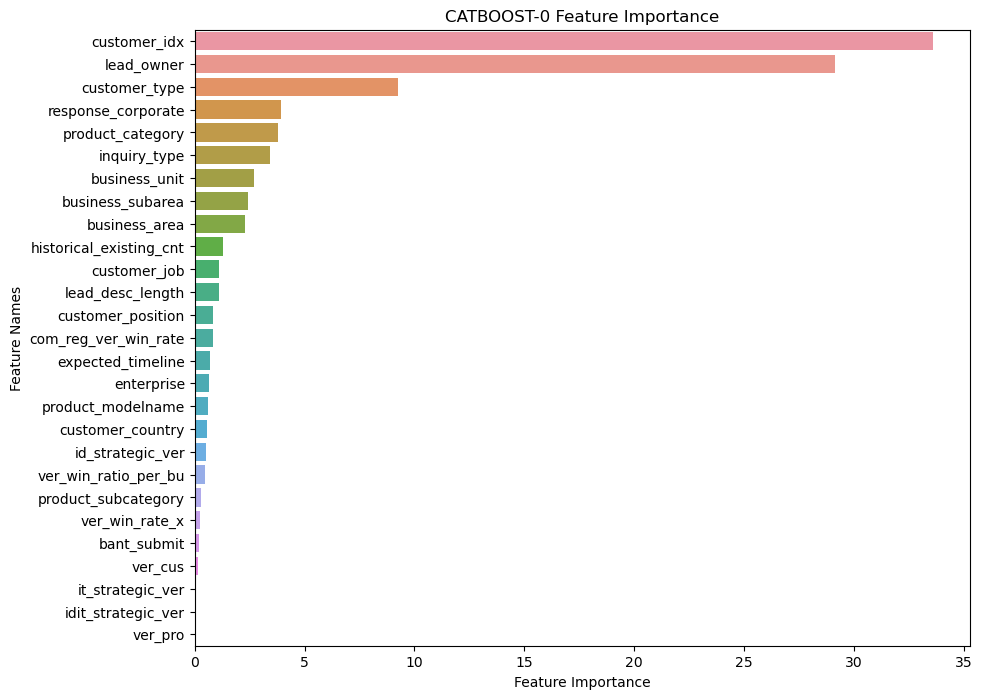

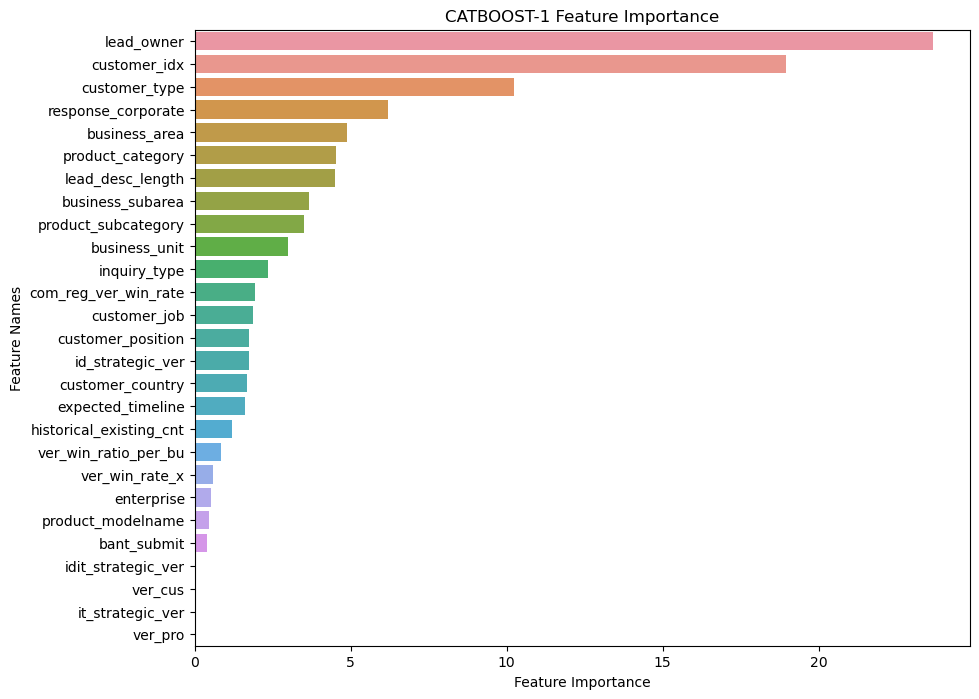

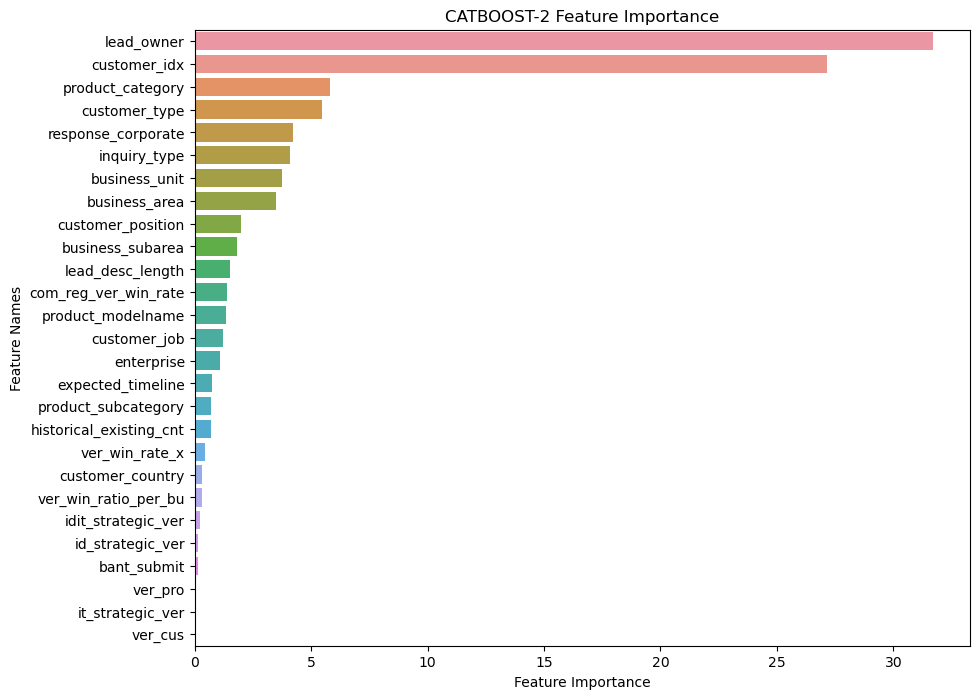

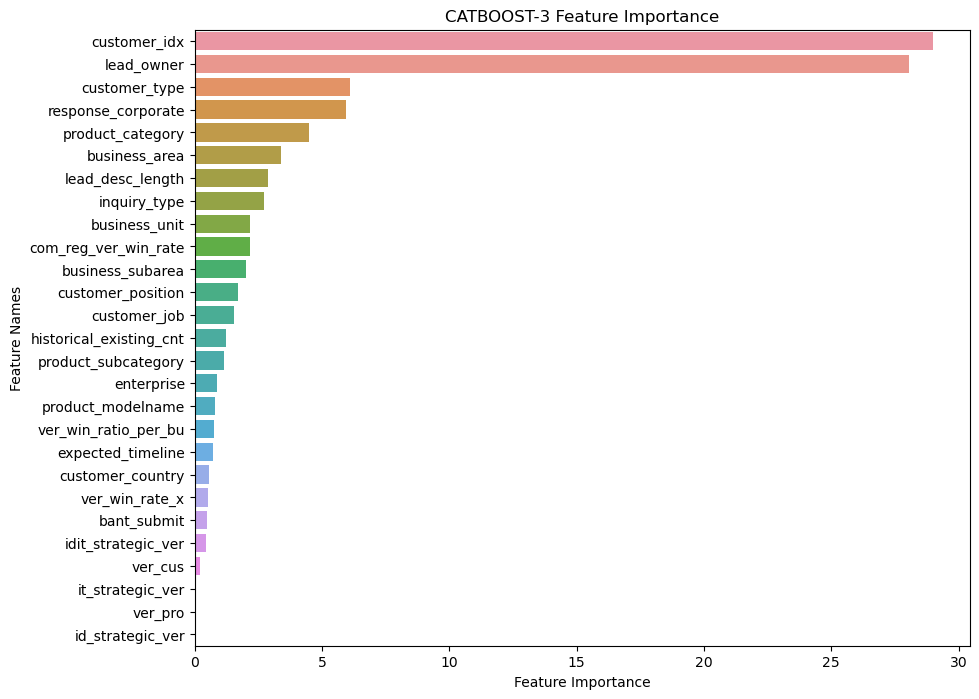

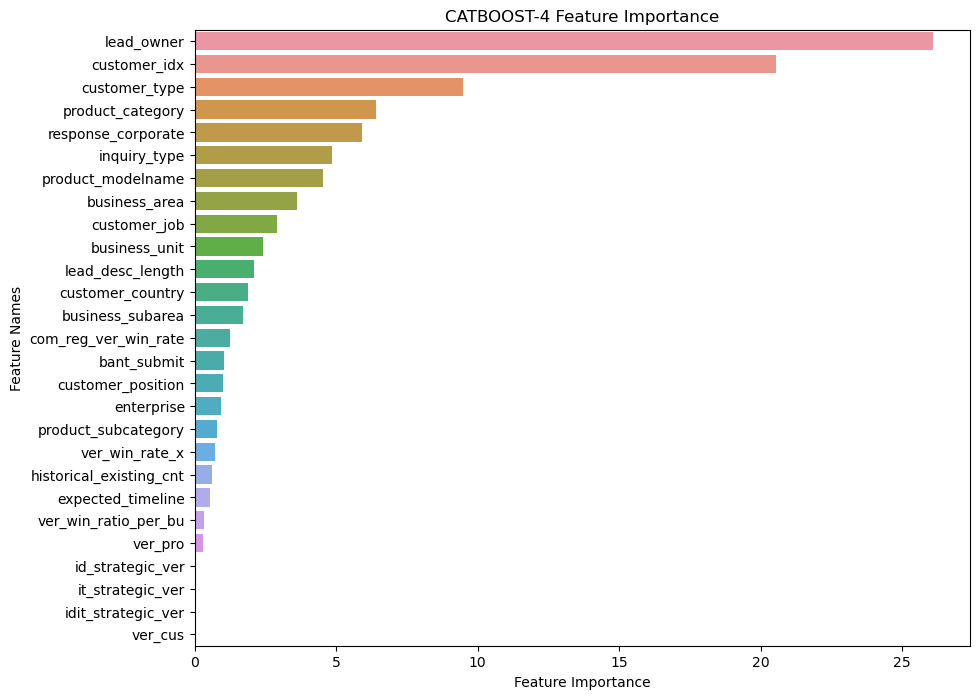

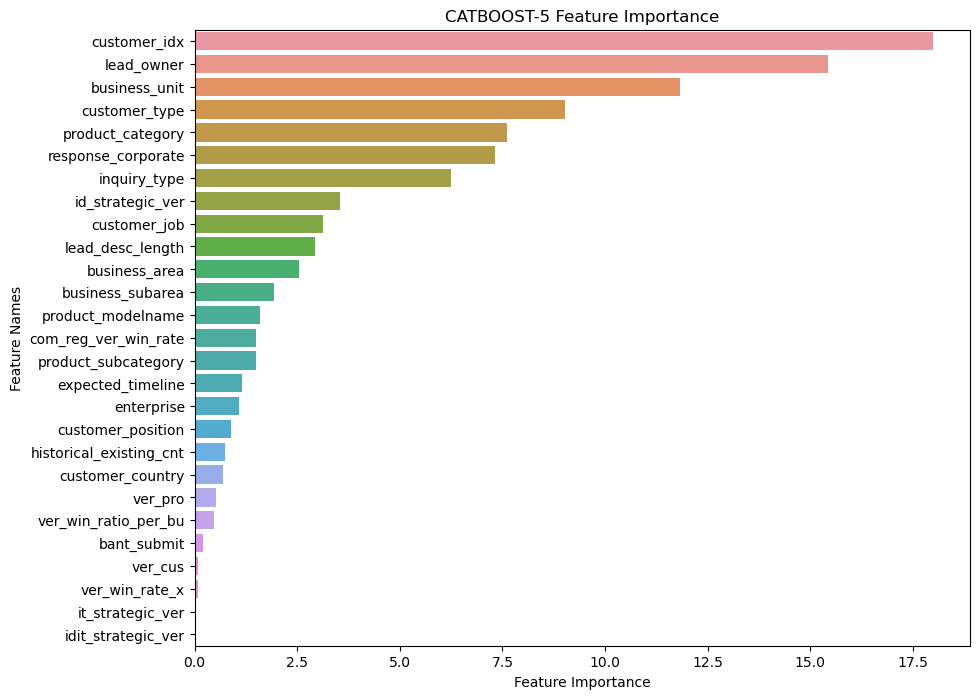

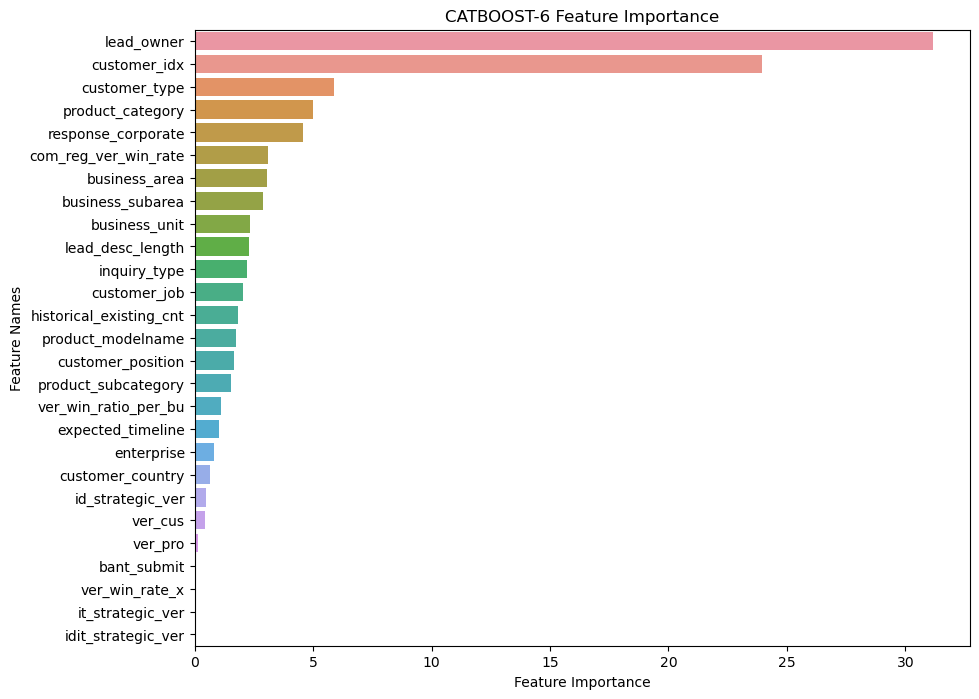

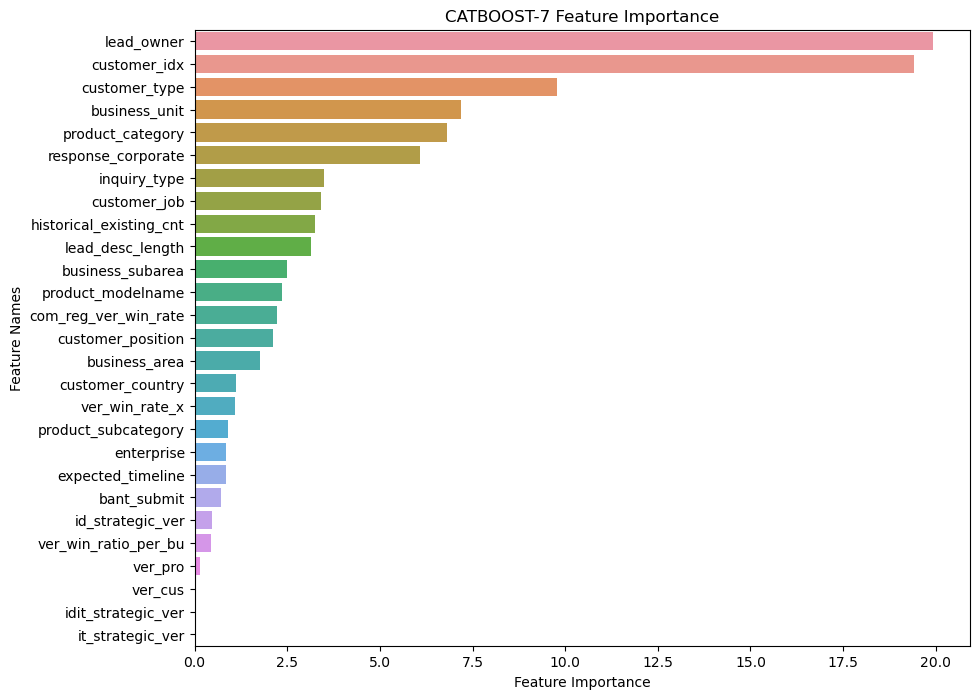

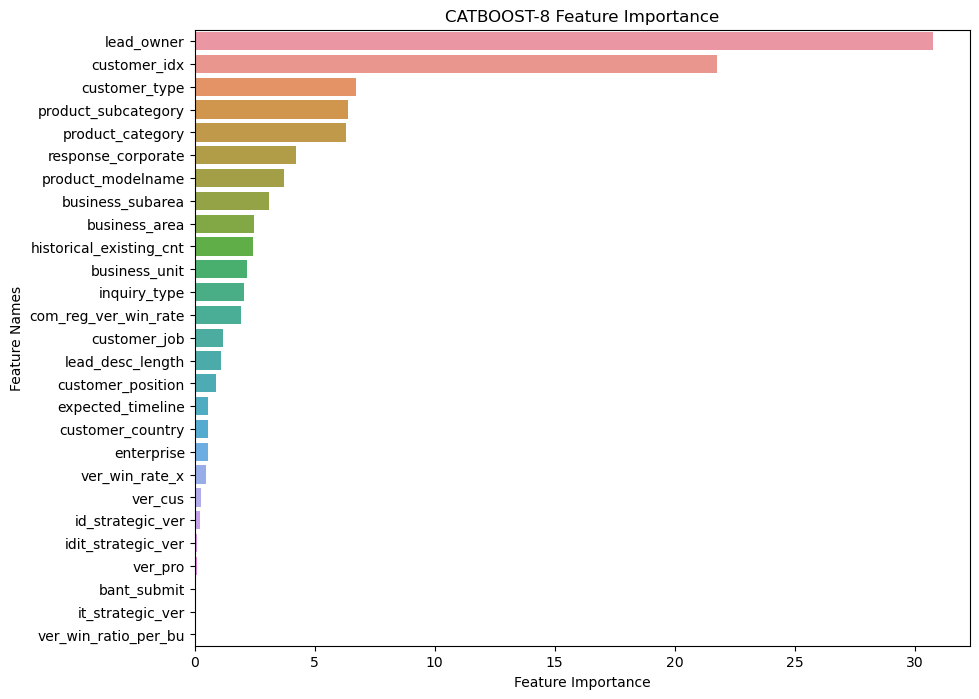

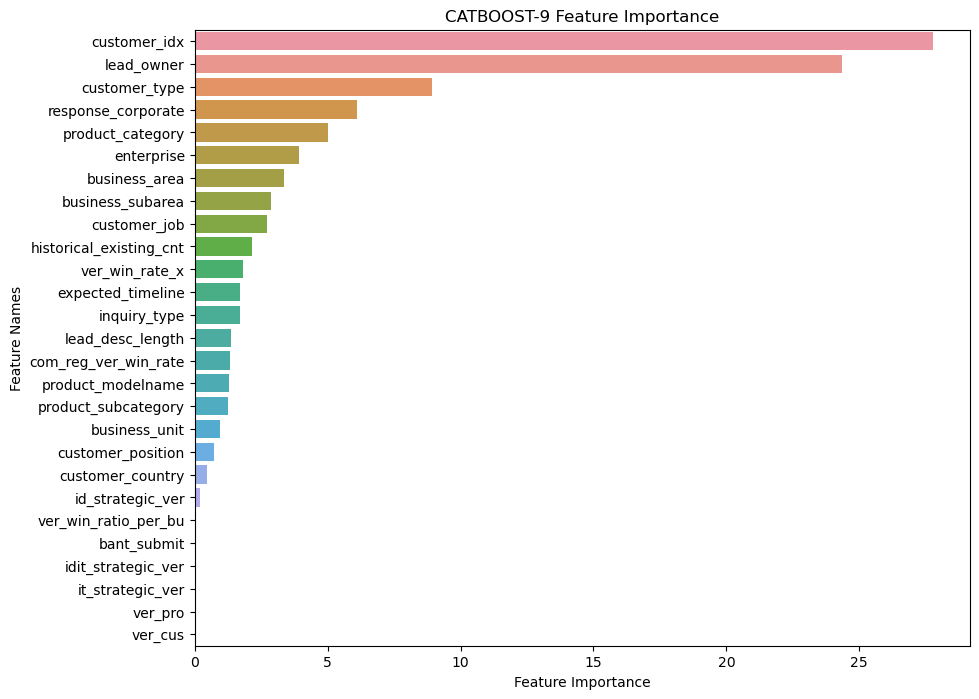

In [164]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in range(10):
    plot_feature_importance(best_models[i].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,f'CATBOOST-{i}')

In [133]:
train_pred = np.mean([best_model.predict_proba(df_train.drop("is_converted",axis=1)) for best_model in best_models], axis=0)
y = list(df_train['is_converted'])
threshold = min([num[1] if y[i] else 1 for i, num in enumerate(train_pred)])
train_y_pred = [True if i[1]>=0.5 else False for i in train_pred]
get_clf_eval(y, train_y_pred)

오차행렬:
 [[ 4610    10]
 [  690 50470]]

정확도: 0.9875
정밀도: 0.8698
재현율: 0.9978
F1: 0.9294


In [134]:
# all_train_pool = []
# all_val_pool = []
# all_y_val = []
for i in range(10):
    train_pred = np.mean([best_model.predict_proba(all_val_pool[i]) for best_model in best_models], axis=0)
    train_pred = np.argmax(train_pred, axis=1)
    get_clf_eval(all_y_val[i], train_pred)

오차행렬:
 [[ 461    1]
 [  88 5028]]

정확도: 0.9840
정밀도: 0.8397
재현율: 0.9978
F1: 0.9120
오차행렬:
 [[ 461    1]
 [  61 5055]]

정확도: 0.9889
정밀도: 0.8831
재현율: 0.9978
F1: 0.9370
오차행렬:
 [[ 461    1]
 [  70 5046]]

정확도: 0.9873
정밀도: 0.8682
재현율: 0.9978
F1: 0.9285
오차행렬:
 [[ 461    1]
 [  74 5042]]

정확도: 0.9866
정밀도: 0.8617
재현율: 0.9978
F1: 0.9248
오차행렬:
 [[ 461    1]
 [  70 5046]]

정확도: 0.9873
정밀도: 0.8682
재현율: 0.9978
F1: 0.9285
오차행렬:
 [[ 460    2]
 [  47 5069]]

정확도: 0.9912
정밀도: 0.9073
재현율: 0.9957
F1: 0.9494
오차행렬:
 [[ 462    0]
 [  69 5047]]

정확도: 0.9876
정밀도: 0.8701
재현율: 1.0000
F1: 0.9305
오차행렬:
 [[ 462    0]
 [  73 5043]]

정확도: 0.9869
정밀도: 0.8636
재현율: 1.0000
F1: 0.9268
오차행렬:
 [[ 459    3]
 [  70 5046]]

정확도: 0.9869
정밀도: 0.8677
재현율: 0.9935
F1: 0.9263
오차행렬:
 [[ 462    0]
 [  68 5048]]

정확도: 0.9878
정밀도: 0.8717
재현율: 1.0000
F1: 0.9315
